# 08 SEI Degradation Model

In this notebook an SEI EC Reaction driven degradation model is created in a similar fashion to Changing a model notebook example using a sim_func. This notebook demonstrates the ageing of cells in a battery pack.

In [1]:
try:
    import liionpack as lp
except ModuleNotFoundError:
    !pip install -q git+https://github.com/pybamm-team/liionpack.git@main
    import liionpack as lp
import pybamm
import numpy as np

A 4-parallel 1-series (4p1s) pack is defined.

In [2]:
I_mag = 30.0
OCV_init = 4.0  # used for intial guess
Ri_init = 5e-2  # used for intial guess
R_busbar = 1.5e-3
R_connection = 1e-2
Np = 4
Ns = 1
Nbatt = Np * Ns

Let's create a netlist

In [3]:
netlist = lp.setup_circuit(
    Np=Np, Ns=Ns, Rb=R_busbar, Rc=R_connection, Ri=Ri_init, V=OCV_init, I=I_mag
)

Following experimental protocol with 100 cycles is used for the pack simulation. This will be the applied terminal current for each time step. 

In [4]:
experiment = pybamm.Experiment(
    [
        "Charge at 15 A for 10 minutes",
        "Rest for 10 minutes",
        "Discharge at 15 A for 10 minutes",
        "Rest for 10 minutes",
    ]
    * 100,
    period="30 seconds",
)

Chen2020 parameter set collected for the LG M50 21700 5 Ah cell is used in the simulation.

In [5]:
parameter_values = pybamm.ParameterValues("Chen2020")

Let's pick a variables for the output

In [6]:
output_variables = [
    "X-averaged positive total SEI thickness [m]",
    "X-averaged negative total SEI thickness [m]",
    "Loss of capacity to positive SEI [A.h]",
    "Loss of capacity to negative SEI [A.h]",
]

Let's define a new sim_func called `SEI_degradation` and pass it to the solver

In [7]:
def SEI_degradation(parameter_values=None):
    """
    Create a PyBaMM simulation set up for integration with liionpack

    Args:
        parameter_values (pybamm.ParameterValues):
            The default is None.

    Returns:
        pybamm.Simulation:
            A simulation that can be solved individually or passed into the
            liionpack solve method

    """
    # Create the pybamm model
    model = pybamm.lithium_ion.SPM(
        options={
            "SEI": "ec reaction limited",
            "SEI film resistance": "distributed",
            "SEI porosity change": "true",
        }
    )

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        parameter_values = pybamm.ParameterValues("Chen2020")

    # Set up solver and simulation
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(
        model=model,
        parameter_values=parameter_values,
        solver=solver,
    )

    return sim

In [8]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=SEI_degradation,
    output_variables=output_variables,
    initial_soc=0.5,
)

Stepping simulation: 100%|██████████| 20/20 [00:00<00:00, 155.10it/s]


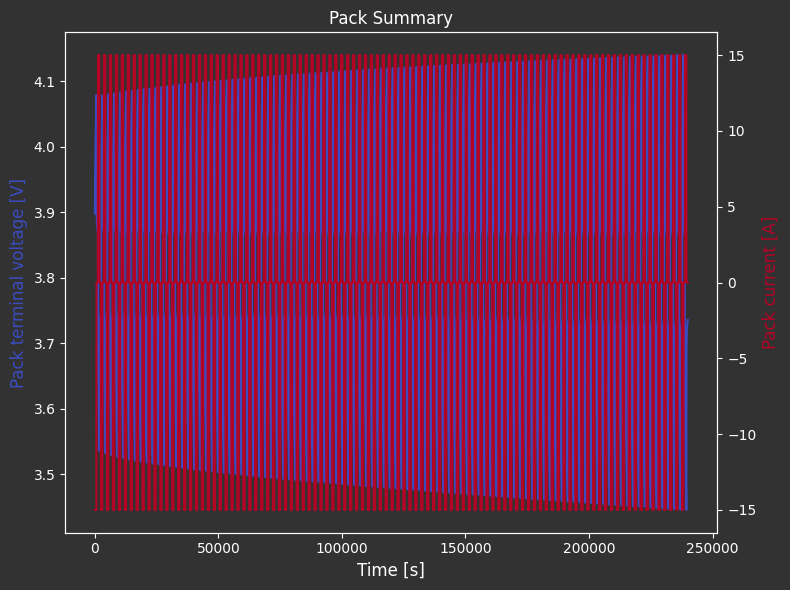

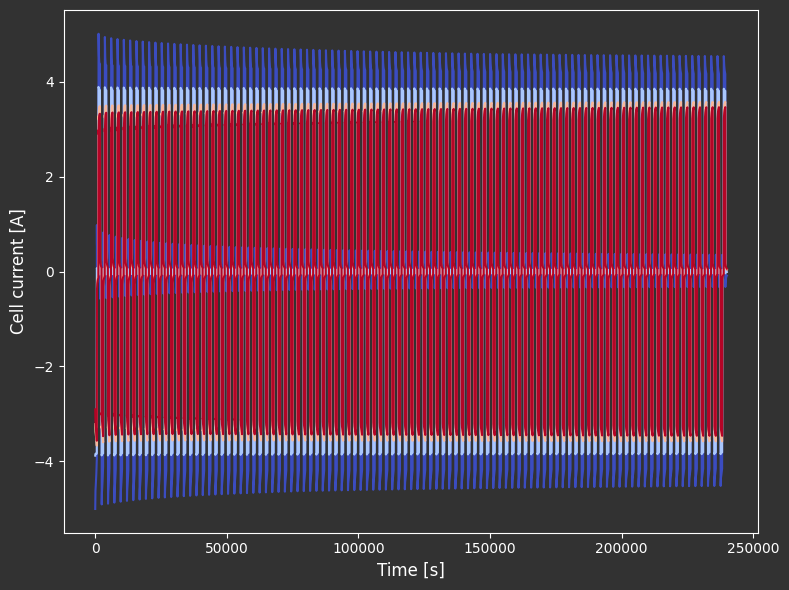

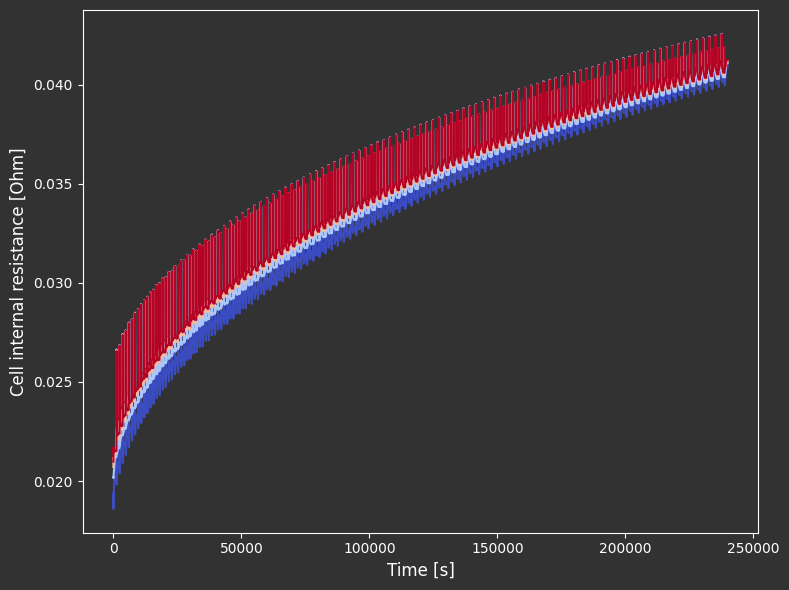

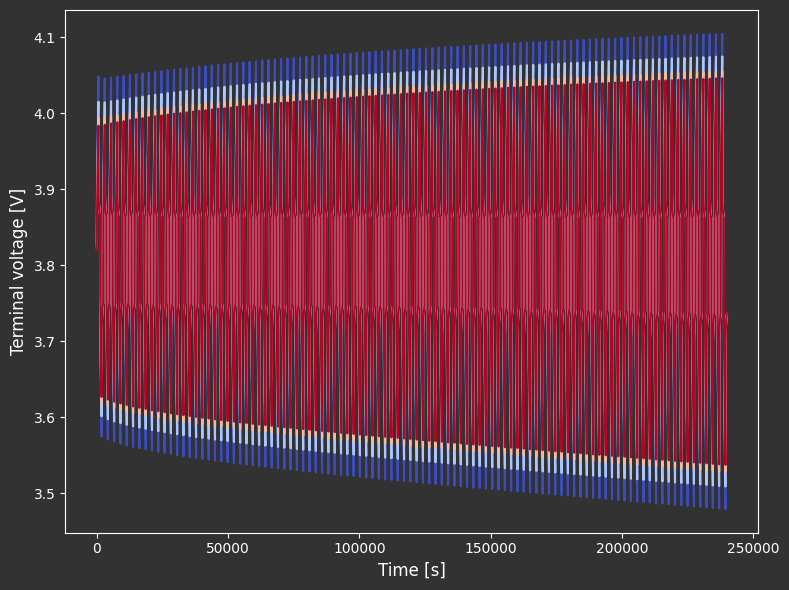

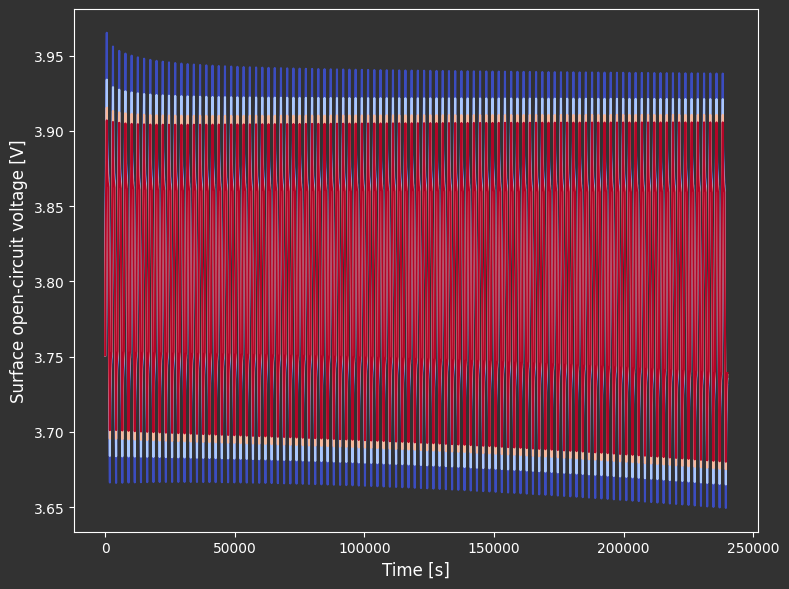

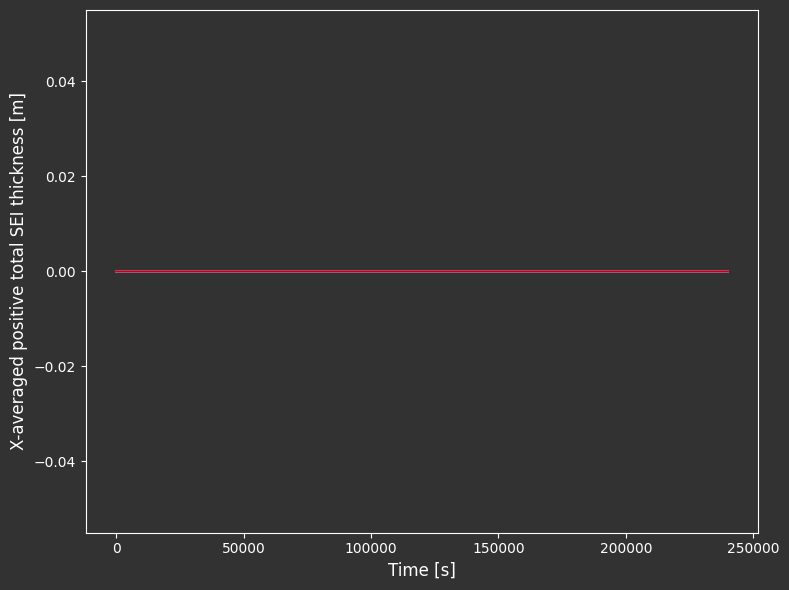

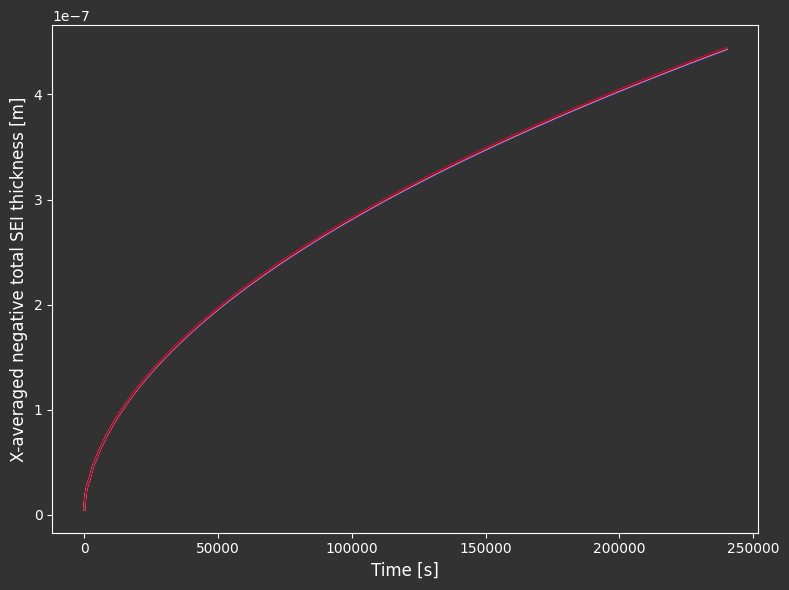

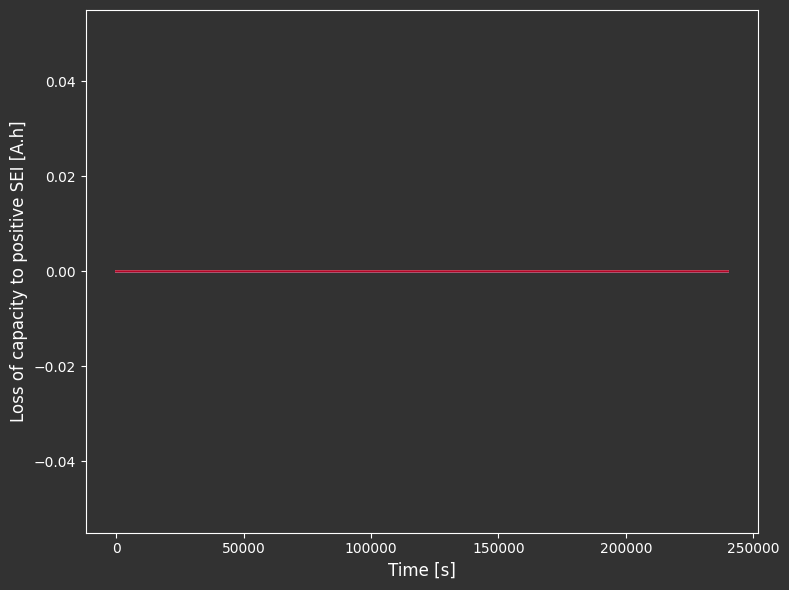

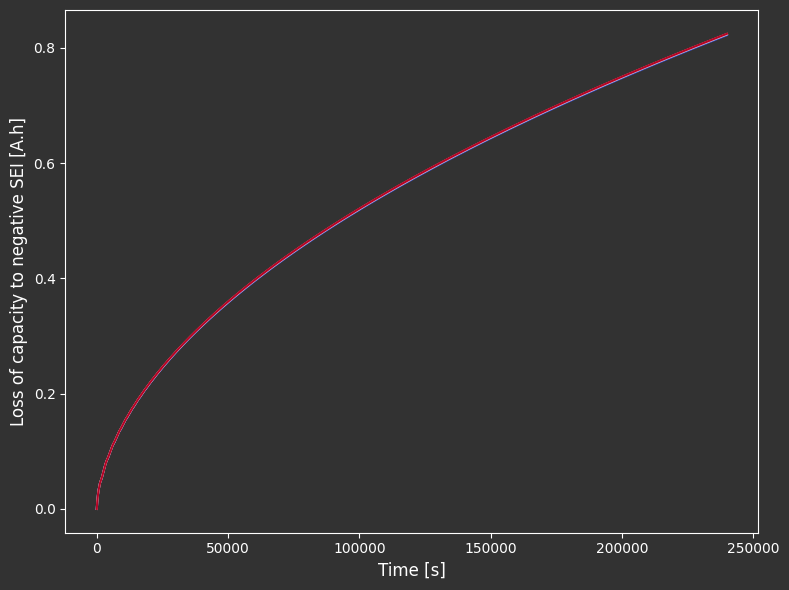

In [9]:
lp.plot_output(output)

We can change the EC initial concentration in electrolyte [mol.m-3] for each cell and see the capacity loss for each cell.

In [10]:
parameter_values.update(
    {"EC initial concentration in electrolyte [mol.m-3]": "[input]"}
)
EC_conc = np.array([4000.0, 3500.0, 3000.0, 2500.0])
inputs = {"EC initial concentration in electrolyte [mol.m-3]": EC_conc}

In [11]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=SEI_degradation,
    inputs=inputs,
    output_variables=output_variables,
    initial_soc=0.5,
)

Stepping simulation: 100%|██████████| 20/20 [00:00<00:00, 156.22it/s]


In [12]:
lp.plot_output(output)